In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class FraudDetection:
    def __init__(self, cc_info_path, transactions_path):
        self.cc_info_path = 'cc_info.csv' 
        self.transactions_path = 'transactions.csv' 
        self.cc_info = pd.read_csv(cc_info_path)
        self.transactions = pd.read_csv(transactions_path)
        self.data = None
        self.model = None

    def preprocess_data(self):
        self.cc_info = pd.read_csv('cc_info.csv') 
        self.transactions = pd.read_csv('transactions.csv') 
        print("Shape of Credit Card Info Data:", self.cc_info.shape)
        print("Shape of Transactions Data:", self.transactions.shape)

        self.data = pd.merge(self.transactions, self.cc_info, on='credit_card', how='inner')
        print("\nPreview of Merged Data:")
        print(self.data.head())
        print("\nShape of Merged Data:", self.data.shape)
        print("\nChecking for missing values before dropping:")
        print(self.data.isnull().sum())
        self.data.dropna(inplace=True)
        print("\nShape after dropping missing values:", self.data.shape)

        if self.data.empty:
            raise ValueError("The dataset is empty after preprocessing. Please check the input data and merging process.")
        self.data['transaction_percentage'] = self.data['transaction_dollar_amount'] / self.data['credit_card_limit']
        print("\nPreview of Data after Feature Engineering:")
        print(self.data[['transaction_dollar_amount', 'credit_card_limit', 'transaction_percentage']].head())
        features = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit', 'transaction_percentage']
        self.data = self.data[features]
        print("\nPreview of Selected Features:")
        print(self.data.head())
        scaler = StandardScaler()
        self.data_scaled = scaler.fit_transform(self.data)
        print("\nData scaling completed successfully.")

    def build_autoencoder(self, input_dim):
        self.model = Sequential([
            Dense(64, input_dim=input_dim, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(input_dim, activation='linear')])
        self.model.compile(optimizer='adam', loss='mse')

    def train_model(self, epochs=20, batch_size=32):
        X_train, X_val = train_test_split(self.data_scaled, test_size=0.2, random_state=42)
        self.model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, X_val), verbose=1)

    def detect_anomalies(self, threshold=0.01):
        reconstructions = self.model.predict(self.data_scaled)
        reconstruction_errors = np.mean(np.square(self.data_scaled - reconstructions), axis=1)
        anomaly_threshold = np.percentile(reconstruction_errors, 100 * (1 - threshold))
        self.data['anomaly'] = (reconstruction_errors > anomaly_threshold).astype(int)   
        return self.data[['anomaly', 'transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit', 'transaction_percentage']]

    def visualize_results(self):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.data, x='Long', y='Lat', hue='anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.6)
        plt.title('Geographical Distribution of Anomalies')
        plt.xlabel('Longitude')
       

Preprocessing Data...
Shape of Credit Card Info Data: (984, 5)
Shape of Transactions Data: (294588, 5)

Preview of Merged Data:
    credit_card              date  transaction_dollar_amount       Long  \
0  1.000000e+15    9/11/2015 0:32                      43.78 -80.174132   
1  1.010000e+15  10/24/2015 22:23                     103.15 -80.194240   
2  1.020000e+15  10/26/2015 18:19                      48.55 -80.211033   
3  1.070000e+15  10/22/2015 19:41                     136.18 -80.174138   
4  1.080000e+15  10/26/2015 20:08                      71.82 -80.238720   

         Lat        city state  zipcode  credit_card_limit  
0  40.267370     Houston    PA    15342              20000  
1  40.180114  Washington    NH     3280              15000  
2  40.313004   Charlotte    VT     5445              28000  
3  40.290895      Dallas    PA    18612              10000  
4  40.166719     Houston    PA    15342              10000  

Shape of Merged Data: (8641, 9)

Checking for missing 

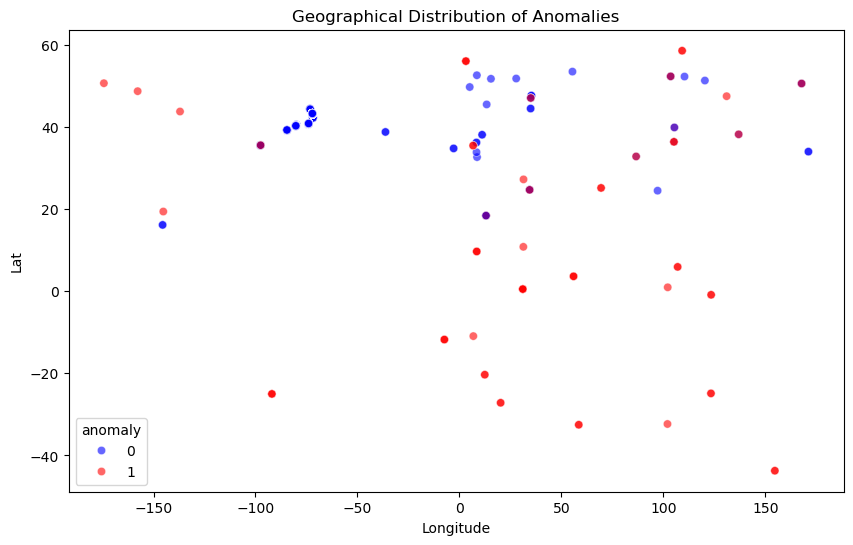

In [3]:
if __name__ == "__main__":
    fraud_detection = FraudDetection('cc_info.csv', 'transactions.csv')
    
    print("Preprocessing Data...")
    fraud_detection.preprocess_data()

    print("Building Autoencoder Model...")
    fraud_detection.build_autoencoder(input_dim=fraud_detection.data_scaled.shape[1])

    print("Training Model...")
    fraud_detection.train_model(epochs=50, batch_size=64)

    print("Detecting Anomalies...")
    results = fraud_detection.detect_anomalies(threshold=0.01)
    print("\nAnomalies Detected:")
    print(results.head())

    print("Visualizing Results...")
    fraud_detection.visualize_results()

    results.to_csv('fraud_detection_results.csv', index=False)
    print("\nResults saved to 'fraud_detection_results.csv'")